**Importations utiles**

In [ ]:
import math, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tfFR7615589351320376517914051
print("Tensorflow version " + tf.__version__)

import warnings
warnings.filterwarnings('ignore')

**Données**

In [3]:
# Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
                )
test_datagen = ImageDataGenerator( rescale = 1./255)

In [8]:
# Données de Kaggle "is that santa image classification"

training_set = train_datagen.flow_from_directory('/kaggle/input/is-that-santa-image-classification/is that santa/train',
                                                 target_size = (64, 64), 
                                                 batch_size = 32, 
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/kaggle/input/is-that-santa-image-classification/is that santa/test', 
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 614 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


Found 614 images belonging to 2 classes.
Found 614 images belonging to 2 classes.


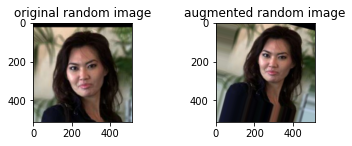

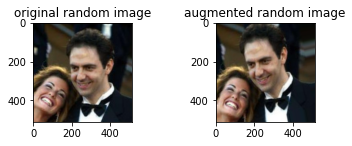

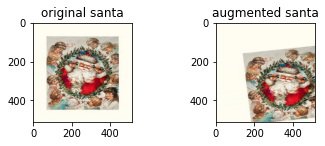

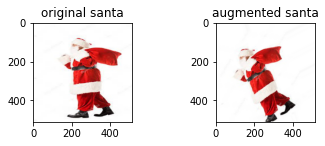

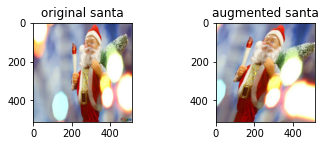

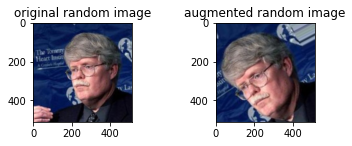

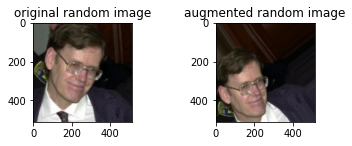

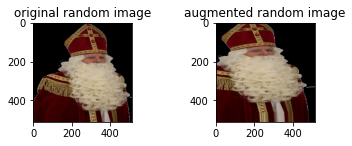

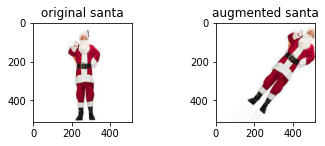

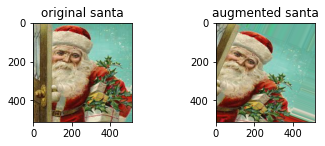

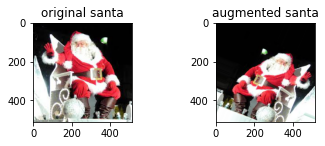

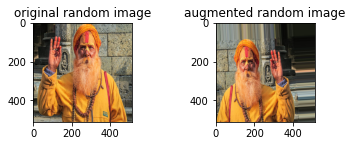

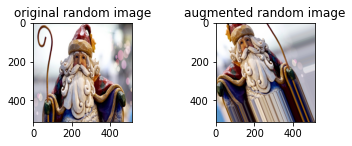

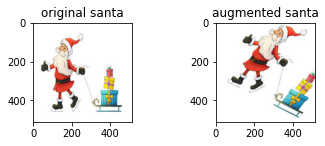

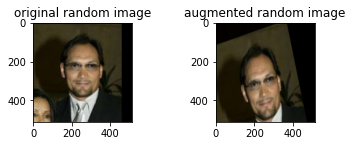

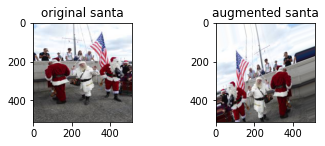

In [5]:
# Pour observer les données augmentées

batches_real = test_datagen.flow_from_directory('/kaggle/input/is-that-santa-image-classification/is that santa/train', 
                                                target_size = (512, 512), batch_size = 16, class_mode = 'categorical', seed=1234)
batches_augmented = train_datagen.flow_from_directory('/kaggle/input/is-that-santa-image-classification/is that santa/train', 
                                                      target_size = (512, 512), batch_size = 16, class_mode = 'categorical', seed=1234)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

for i in range(16):
    image_augmented = x_batch_augmented[i]
    image_real = x_batch_real[i]
    
    title_add_on = "random image"
    if y_batch_augmented[i][1]: title_add_on =  "santa"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)

        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)

    plt.show()

**Construction d'un modèle CNN**

In [10]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Sequential, layers

classifier = Sequential([
    layers.Conv2D(filters = 32, 
                kernel_size = 1,
                strides = 1,
                activation = "relu",
                padding = "same",
                input_shape = (64, 64, 3)),
    layers.MaxPooling2D(pool_size = 2, strides = 2, padding ='same'),
    layers.Dropout(0.2),
    layers.Conv2D(filters = 32, 
                kernel_size = 3,
                strides = 1,
                activation = "relu",
                padding = "same",
                input_shape = (30, 30, 3)),
    layers.MaxPooling2D(pool_size = 2, strides = 2, padding ='same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 2, activation = 'sigmoid')
])

**Compilation, callbacks et entraînement**

In [11]:
classifier.compile(loss = 'binary_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['binary_accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 5, 
                                min_delta = 0.001,  
                                verbose = 1, 
                                monitor ='val_binary_accuracy',
                                restore_best_weights = True)

history = classifier.fit(training_set,
                        validation_data = test_set,
                        #batch_size = 512,
                        epochs = 30,
                        callbacks = early_stopping,
                        verbose = True)

Epoch 1/30
20/20 [==============================] - 17s 825ms/step - loss: 0.8814 - binary_accuracy: 0.4983 - val_loss: 0.6844 - val_binary_accuracy: 0.4984
Epoch 2/30
20/20 [==============================] - 15s 736ms/step - loss: 0.6677 - binary_accuracy: 0.5347 - val_loss: 0.6477 - val_binary_accuracy: 0.6575
Epoch 3/30
20/20 [==============================] - 15s 751ms/step - loss: 0.6281 - binary_accuracy: 0.5935 - val_loss: 0.5517 - val_binary_accuracy: 0.8312
Epoch 4/30
20/20 [==============================] - 15s 727ms/step - loss: 0.5072 - binary_accuracy: 0.7913 - val_loss: 0.4654 - val_binary_accuracy: 0.7898
Epoch 5/30
20/20 [==============================] - 15s 770ms/step - loss: 0.4770 - binary_accuracy: 0.8111 - val_loss: 0.3896 - val_binary_accuracy: 0.8539
Epoch 6/30
20/20 [==============================] - 15s 763ms/step - loss: 0.3552 - binary_accuracy: 0.8472 - val_loss: 0.3921 - val_binary_accuracy: 0.8271
Epoch 7/30
20/20 [==============================] - 15s 79

**Visualisation loss et accuracy**

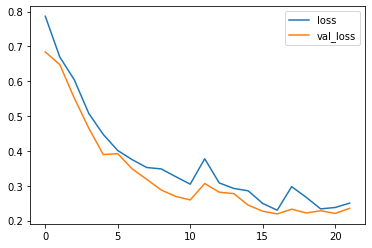

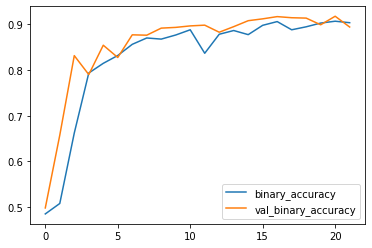

In [12]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

**Application du modèle sur une image**

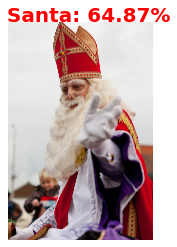

In [36]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

txt ='/kaggle/input/is-that-santa-image-classification/is that santa/train/not-a-santa/155.not-a-santa.jpg' # Préciser le chemin local
test_image = image.load_img(txt, target_size = (64, 64))
test_image = image.img_to_array(test_image)/255
test_image = np.expand_dims(test_image, axis = 0)

proba = round(100*classifier.predict(test_image)[0][1], 2)
if proba < 50:
    santa_or_not = 'Not Santa'
    proba = round(100-proba, 2)
else:
    santa_or_not = 'Santa'
img = mpimg.imread(txt)
plt.axis('off')
plt.text(-10, -15, santa_or_not+': '+str(proba)+'%', color = (1, 0, 0), fontsize = 20, fontweight = 'extra bold')
imgplot = plt.imshow(img)

Testons maintenant si l'on obtient de meilleures performances grâce au transfer learning :

**Transfer Learning**

In [31]:
# On utilise le fameux VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

pretrained_base = VGG16(weights = 'imagenet', include_top = False)
pretrained_base.trainable = False

classifier_2 = Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units = 256, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(units = 2, activation = 'sigmoid')
])

In [32]:
classifier_2.compile(loss = 'binary_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['binary_accuracy'])

history_2 = classifier.fit(training_set,
                        validation_data = test_set,
                        #batch_size = 512,
                        epochs = 30,
                        callbacks = early_stopping,
                        verbose = True)

Epoch 1/30
20/20 [==============================] - 16s 826ms/step - loss: 0.2558 - binary_accuracy: 0.9055 - val_loss: 0.2728 - val_binary_accuracy: 0.8847
Epoch 2/30
20/20 [==============================] - 14s 741ms/step - loss: 0.2560 - binary_accuracy: 0.8966 - val_loss: 0.2297 - val_binary_accuracy: 0.9099
Epoch 3/30
20/20 [==============================] - 15s 747ms/step - loss: 0.2423 - binary_accuracy: 0.9007 - val_loss: 0.2307 - val_binary_accuracy: 0.9115
Epoch 4/30
20/20 [==============================] - 15s 740ms/step - loss: 0.2408 - binary_accuracy: 0.8909 - val_loss: 0.2492 - val_binary_accuracy: 0.8864
Epoch 5/30
20/20 [==============================] - 14s 752ms/step - loss: 0.2533 - binary_accuracy: 0.9015 - val_loss: 0.2237 - val_binary_accuracy: 0.9091
Epoch 6/30
20/20 [==============================] - 15s 760ms/step - loss: 0.2128 - binary_accuracy: 0.9267 - val_loss: 0.2344 - val_binary_accuracy: 0.9058
Epoch 7/30
20/20 [==============================] - 15s 73

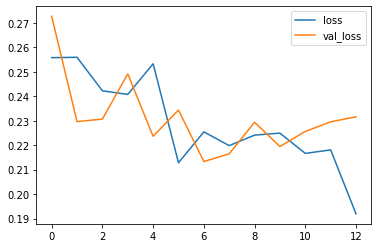

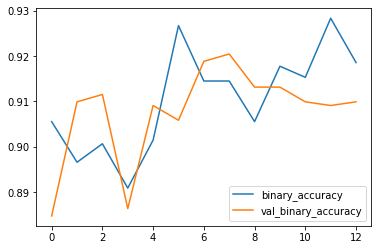

In [33]:
history_frame_2 = pd.DataFrame(history_2.history)
history_frame_2.loc[:, ['loss', 'val_loss']].plot()
history_frame_2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

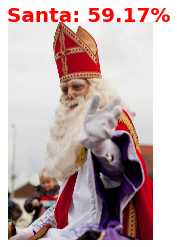

In [35]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

txt ='/kaggle/input/is-that-santa-image-classification/is that santa/train/not-a-santa/155.not-a-santa.jpg' # Préciser le chemin local
test_image = image.load_img(txt, target_size = (64, 64))
test_image = image.img_to_array(test_image)/255
test_image = np.expand_dims(test_image, axis = 0)

proba = round(100*classifier_2.predict(test_image)[0][1], 2)
if proba < 50:
    santa_or_not = 'Not Santa'
    proba = round(100-proba, 2)
else:
    santa_or_not = 'Santa'
img = mpimg.imread(txt)
plt.axis('off')
plt.text(-10, -15, santa_or_not+': '+str(proba)+'%', color = (1, 0, 0), fontsize = 20, fontweight = 'extra bold')
imgplot = plt.imshow(img)